# Modelling stochastic processes in R

- work in progress
- relevant to time series and forecasting

Below we construct six different stochastic processes using R and demonstrate how they differ graphically at the end. The processes are

- White noise
- Moving average
- Random walk
- Autoregression
- Random walk with a constant drift
- Integrated process

This idea follows the demo of select processes in Nausser (*see* Reference material).

In [1]:
# Libraries
library(tidyverse)
library(patchwork)

# Draw seed
set.seed(42)

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
# Data
sample_size <- 500

## White noise (WN) process

- $\epsilon_t \overset{\text{i.i.d.}}{\sim} \mathcal{N}(0, \sigma^2)$
- $X_t = \epsilon_t$
- $\mathbb{E}\left[X_t\right] = 0$
- $\text{Var}(X_t) = \sigma^2$

In [3]:
# WN
wn_series <- rnorm(sample_size, 0, 1)

wn_df <- tibble(
  period = seq_len(sample_size),
  shock = wn_series
)

wn_plot <- ggplot(wn_df, aes(x = period, y = shock)) + 
  geom_line() + 
  labs(
    title = "White noise process"
  ) +
  theme_minimal()

## Moving average (MA) process

For an MA(1) process,

- $\epsilon_t \overset{\text{i.i.d.}}{\sim} \mathcal{N}(0, \sigma^2)$
- $X_t = \theta \epsilon_{t-1} + \epsilon_t$
- $\mathbb{E}\left[X_t\right] = 0$
- $\text{Var}(X_t) = (1 + \theta^2) \sigma^2$
- $\rho(1)=\frac{\gamma(1)}{\gamma(0)}=\frac{\theta}{1+\theta^2}$
- $\rho(k)=\frac{\gamma(k)}{\gamma(0)}=0, \text{for } \neq 1$

In [4]:
# MA(1)
theta <- 0.5

ma_df <- wn_df |>
  mutate(
    ma_observation = shock + theta * lag(shock)
  ) |>
  filter(!is.na(ma_observation))

ma_plot <- ggplot(ma_df, aes(x = period, y = ma_observation)) + 
  geom_line() + 
  labs(
    title = "MA(1) process"
  ) + 
  theme_minimal()

## Random walk (RW) process

- $\epsilon_t \overset{\text{i.i.d.}}{\sim} \mathcal{N}(0, \sigma^2)$
- $X_t = \sum_{i=0}^t \epsilon_i$
- $\mathbb{E}\left[X_t\right]=0$
- $\text{Var}(X_t)=t\sigma^2$

In [5]:
# RW
rw_df <- wn_df |>
  mutate(
    rw_observation = cumsum(shock)
  )

rw_plot <- ggplot(rw_df, aes(x = period, y = rw_observation)) + 
  geom_line() + 
  labs(
    title = "Random walk process"
  ) + 
  theme_minimal()

## Autoregressive (AR) process

For an AR(1) process,

- $\epsilon_t \overset{\text{i.i.d.}}{\sim} \mathcal{N}(0, \sigma^2)$
- $X_t=\phi X_{t-1}+\epsilon_t$
- $\mathbb{E}\left[X_t\right]=X_0$
- $\text{Var}(X_t)=\sigma^2 \sum_{t=0}^\infty \phi^{2t}=\frac{\sigma^2}{1-\phi^2}$

The series converges iff $|\phi|<1$.

Assuming stationarity, $\mathbb{E}\left[X_t\right]=0$.

In [6]:
# AR(1)
phi <- 0.5

ar_vector <- c()

for (i in seq_along(wn_series)) {
  if (i == 1) {
    # X_0 = 0 + \epsilon_0
    ar_vector[1] <- 0 + wn_series[1]
  } else {
    # X_t = \phi * X_{t-1} + \epsilon_t
    ar_vector[i] <- phi * ar_vector[i - 1] + wn_series[i]
  }
}

ar_df <- wn_df |>
  mutate(
    ar_observation = ar_vector
  )

ar_plot <- ggplot(ar_df, aes(x = period, y = ar_observation)) + 
  geom_line() + 
  labs(
    title = "AR(1) process"
  ) + 
  theme_minimal()

## Random walk with a drift

Random walk with a constant drift,

- $\epsilon_t \overset{\text{i.i.d.}}{\sim} \mathcal{N}(0, \sigma^2)$
- $X_t=\delta t +\sum_{i=1}^t \epsilon_{i}$
- $\mathbb{E}\left[X_t\right]=\delta t$
- $\text{Var}(X_t)=t\sigma^2$

In [7]:
# Random walk with a constant drift (Special case of an I(1) process)
delta <- 0.1 # Trend step (drift)

rwd_vector <- c()

for (i in seq_along(wn_series)) {
  if (i == 1) {
    # X_0 = \delta t_{t=0} + 0 + \epsilon_0
    rwd_vector[1] <- delta + 0 + wn_series[1] # X_0
  } else {
    # Deterministic trend \delta t + stochastic trend \sum \epsilon_t
    rwd_vector[i] <- delta + rwd_vector[i - 1] + wn_series[i]
  }
}

rwd_df <- ar_df |>
  mutate(
    rwd_observation = rwd_vector
  )

rwd_plot <- ggplot(rwd_df, aes(x = period, y = rwd_observation)) + 
  geom_line() + 
  labs(
    title = "Random walk with a constant drift"
  ) + 
  theme_minimal()

## Integrated process

An I(1) process with an MA component,

- $\epsilon_t \overset{\text{i.i.d.}}{\sim} \mathcal{N}(0, \sigma^2)$
- $X_t=\delta t+\sum_{i=1}^t (\theta\epsilon_{i-1} + \epsilon_i)$
- $\mathbb{E}\left[X_t\right]=\delta t$
- $\text{Var}(X_t)=\sigma^2\left[t(\theta^2+1)+2(t-1)\right]$

In [8]:
# I(1) process
delta <- 0.1 # Deterministic trend step
theta <- 0.5 # Stochastic trend parameter

dx <- delta + wn_series + theta * lag(wn_series)
dx[1] <- delta + wn_series[1]

i1_df <- wn_df |>
  mutate(
    i1_observation = cumsum(dx)
  )

i1_plot <- ggplot(i1_df, aes(x = period, y = i1_observation)) + 
  geom_line() + 
  labs(
    title = "I(1) process"
  ) + 
  theme_minimal()

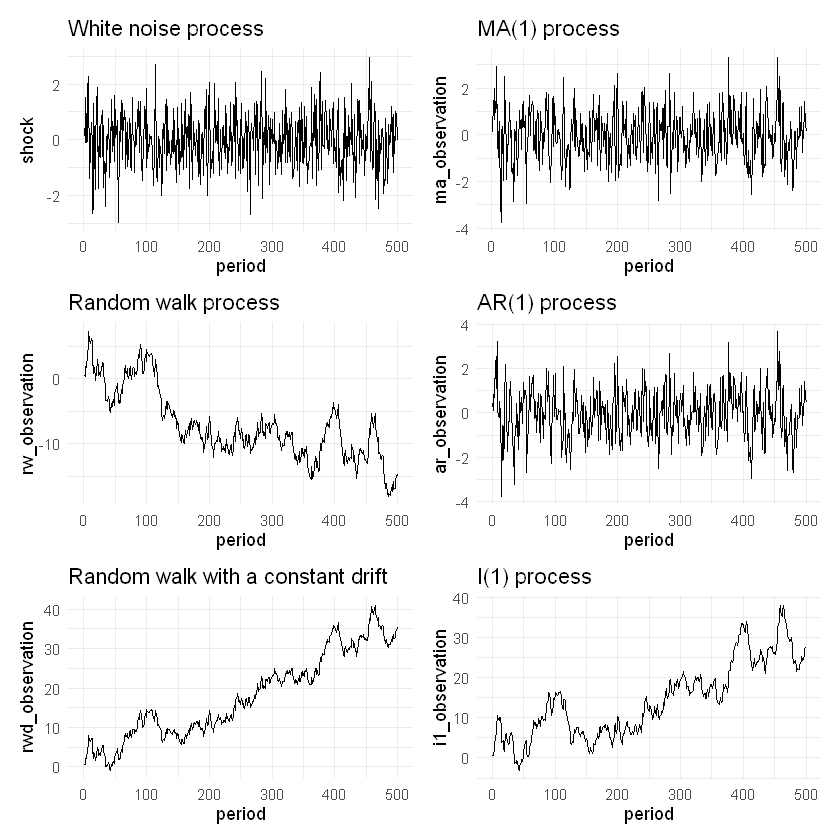

In [9]:
# Plots
print(
  wrap_plots(
    A = wn_plot, 
    B = ma_plot, 
    C = rw_plot, 
    D = ar_plot, 
    E = rwd_plot, 
    G = i1_plot, 
    design = "AABB\nCCDD\nEEGG"
    )
  )

## Reference material:

Canova, F. (2007) *Methods for Applied Macroeconomic Research*. Princeton University Press.

Chatfield, C. and Xing, H. (2019) *The Analysis of Time Series: An Introduction with R*, 7th edn. Chapman & Hall/CRC.

Cryer, D.J. and Chan, K.S. (2008) *Time Series Analysis with Applications in R*, 2nd edn. Springer.

Geweke, J. and Whiteman, C. (2006) ‘Chapter 1 Bayesian Forecasting’ in Elliott, G. et al. (eds) *Handbook of Economic Forecasting*, Volume 1. https://doi.org/10.1016/S1574-0706(05)01001-3

Hamilton, J.D. (1994) *Time Series Analysis*. Princeton University Press.

Koop, G. and Korobilis, D. (2009) ‘Bayesian Multivariate Time Series Methods for Empirical
Macroeconomics’. http://dx.doi.org/10.2139/ssrn.1514412

Lütkepohl, H. (2005) *New Introduction to Multiple Time Series Analysis*. Springer.

Lütkepohl, H. and Krätzig, M. (2004) *Applied Time Series Econometrics*. Cambridge University Press.

Neusser, K. (2016) *Time Series Econometrics*. Springer.

Pfaff, B. (2008) *Analysis of Integrated and Cointegrated Time Series with R*, 2nd edn. Springer.